# Fraud detection - Transactions

## Tasks
- Explore and visualize dataset
- Prepare dataset for fitting
- Configure regression model
- Fit model
- Evaluate model



In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import random
import seaborn as sns

In [2]:
# dfs = pd.read_csv('sample_submission.csv', low_memory=False, index_col='TransactionID')
# print(dfs.shape)

In [3]:
# Load data
def load_data(file_train, file_test):
    print('Loading data...')
    df_train = pd.read_csv(file_train, low_memory=False, index_col='TransactionID')
    print(f'Shape of {file_train}: {df_train.shape}')
    df_test = pd.read_csv(file_test, low_memory=False, index_col='TransactionID')
    print(f'Shape of {file_test}: {df_test.shape}')
    return df_train, df_test

# Clean data
def clean_data(df_train, df_test, plim=0.20):
    # Remove coloums with more than plim (default 20%) invalid values
    col = [x for x in df_train.columns if df_train[x].isna().sum() > int(df_train.shape[0]*plim)]
    print("Too many NAN's in train: ", col)
    df_train.drop(col, axis=1, inplace=True)
    df_test.drop(col, axis=1, inplace=True)
    col = [x for x in df_test.columns if df_test[x].isna().sum() > int(df_test.shape[0]*plim)]
    if len(col) > 0:
        print("Too many NAN's in test: ", col)
        df_train.drop(col, axis=1, inplace=True)
        df_test.drop(col, axis=1, inplace=True)
    print(f'Shape of train data: {df_train.shape}')
    print(f'Shape of test data: {df_test.shape}')

# Preprocess data
df_id_tr, df_id_te = load_data('train_identity.csv', 'test_identity.csv')
clean_data(df_id_tr, df_id_te)
df_ta_tr, df_ta_te = load_data('train_transaction.csv', 'test_transaction.csv')
clean_data(df_ta_tr, df_ta_te)

Loading data...
Shape of train_identity.csv: (144233, 40)
Shape of test_identity.csv: (141907, 40)
Too many NAN's in train:  ['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
Shape of train data: (144233, 21)
Shape of test data: (141907, 21)
Loading data...
Shape of train_transaction.csv: (590540, 393)
Shape of test_transaction.csv: (506691, 392)
Too many NAN's in train:  ['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',

In [4]:
# Function for combining and splitting train and test data
def concat_data(df_train, df_test):
    # Concat the 2 datasets
    print("Concat train", df_train.shape)
    print("Concat test", df_test.shape)
    split = df_train.shape[0]
    dfc = pd.concat([df_train, df_test])
    print("Concat data", dfc.shape)
    return dfc, split

def split_data(dfc, split):
    print("Split data", dfc.shape)
    df_train = dfc[0:split]
    df_test = dfc[split:]
    print("Split train", df_train.shape)
    print("Split test", df_test.shape)
    return df_train, df_test

def combine_data(df1, df2):
    # Combine the 2 datasets
    print("Combine 1", df1.shape)
    print("Combine 2", df2.shape)
    # dfc = pd.concat([df1, df2], axis=1, 'sort=False')
    dfc = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
    print("Combined", dfc.shape)
    return dfc

# Get the label data
if 'isFraud' in df_ta_tr.columns:
    y = df_ta_tr.pop('isFraud')
# Combine data and prepare for label encoding and scaling
df_train = combine_data(df_ta_tr, df_id_tr)
df_test = combine_data(df_ta_te, df_id_te)
# df_id, split_id = concat_data(df_id_tr, df_id_te)
# dx_tr, dx_te = split_data(df_id, split_id)
# # dx_tr.equals(df_id_tr)
# # dx_te.equals(df_id_te)
# One big data set, train/test index is set by split
df_all, split = concat_data(df_train, df_test)

Combine 1 (590540, 180)
Combine 2 (144233, 21)
Combined (590540, 201)
Combine 1 (506691, 180)
Combine 2 (141907, 21)
Combined (506691, 201)
Concat train (590540, 201)
Concat test (506691, 201)
Concat data (1097231, 201)


In [5]:
# Encode string type data
def encode_data(df):
    # See https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    scols = df.select_dtypes(include='object').columns
    if len(scols) > 0:
        # Create a label (category) encoder object
        le = LabelEncoder()
        print(df[scols].head())
        for col in scols:
            df[col] = le.fit_transform(list(df[col]))
        print(df[scols].head())

encode_data(df_all)

              ProductCD       card4   card6 P_emaildomain     id_12 id_15  \
TransactionID                                                               
2987000               W    discover  credit           NaN       NaN   NaN   
2987001               W  mastercard  credit     gmail.com       NaN   NaN   
2987002               W        visa   debit   outlook.com       NaN   NaN   
2987003               W  mastercard   debit     yahoo.com       NaN   NaN   
2987004               H  mastercard  credit     gmail.com  NotFound   New   

                  id_16 id_28     id_29                id_31 id_35 id_36  \
TransactionID                                                              
2987000             NaN   NaN       NaN                  NaN   NaN   NaN   
2987001             NaN   NaN       NaN                  NaN   NaN   NaN   
2987002             NaN   NaN       NaN                  NaN   NaN   NaN   
2987003             NaN   NaN       NaN                  NaN   NaN   NaN   
2987

In [6]:
# Check for NaN
df_all.fillna(-10000.0, inplace=True)

In [7]:
# Split data for scale and fit
d_regression_data, d_predict = split_data(df_all, split)
X_train, X_test, y_train, y_test = train_test_split(d_regression_data, y, test_size = 0.15)
X_predict = np.array(d_predict)
# Check shape of data
print("y shape:", y.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Split data (1097231, 201)
Split train (590540, 201)
Split test (506691, 201)
y shape: (590540,)
X_train shape: (501959, 201)
X_test shape: (88581, 201)
y_train shape: (501959,)
y_test shape: (88581,)


In [8]:
# Scale
scaler = StandardScaler()
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [9]:
logistic = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
logistic.fit(X_train, y_train)
print(f'Score: {logistic.score(X_test, y_test):.4f}')

C:\Users\thka\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Score: 0.9660


Postanalyze data

In [10]:
y_predicted = np.array(logistic.predict(X_test))
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     85477
           1       0.70      0.05      0.10      3104

    accuracy                           0.97     88581
   macro avg       0.83      0.53      0.54     88581
weighted avg       0.96      0.97      0.95     88581



In [11]:
corr = df_all.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

DeviceInfo  DeviceInfo    1.000000e+00
V126        V126          1.000000e+00
V128        V128          1.000000e+00
V129        V129          1.000000e+00
V130        V130          1.000000e+00
                              ...     
V91         C6            8.893486e-07
C13         V291          3.777051e-07
V291        C13           3.777051e-07
C3          V290          3.564225e-07
V290        C3            3.564225e-07
Length: 40401, dtype: float64

In [15]:
dff = df_train
encode_data(dff)

              ProductCD       card4   card6 P_emaildomain     id_12 id_15  \
TransactionID                                                               
2987000               W    discover  credit           NaN       NaN   NaN   
2987001               W  mastercard  credit     gmail.com       NaN   NaN   
2987002               W        visa   debit   outlook.com       NaN   NaN   
2987003               W  mastercard   debit     yahoo.com       NaN   NaN   
2987004               H  mastercard  credit     gmail.com  NotFound   New   

                  id_16 id_28     id_29                id_31 id_35 id_36  \
TransactionID                                                              
2987000             NaN   NaN       NaN                  NaN   NaN   NaN   
2987001             NaN   NaN       NaN                  NaN   NaN   NaN   
2987002             NaN   NaN       NaN                  NaN   NaN   NaN   
2987003             NaN   NaN       NaN                  NaN   NaN   NaN   
2987

In [20]:
c = []
for col in dff.columns:
    c.append((col, y.corr(dff[col])))

In [21]:
sorted(c, key=lambda x: x[-1])

[('id_35', -0.16423560147873442),
 ('ProductCD', -0.15655631946488938),
 ('id_29', -0.15193990232809423),
 ('id_28', -0.15063963829649663),
 ('id_38', -0.14512405669762926),
 ('id_16', -0.14372554651161404),
 ('id_15', -0.1437252919441313),
 ('id_36', -0.13823420095349753),
 ('id_31', -0.12667390040947538),
 ('id_01', -0.12009888526804516),
 ('id_37', -0.11993917823419745),
 ('id_12', -0.11979397642973336),
 ('DeviceType', -0.11269773549259852),
 ('V90', -0.11016802850924881),
 ('V29', -0.10785177266358283),
 ('V91', -0.10545301705361108),
 ('V69', -0.10452063087877916),
 ('V30', -0.10308792418959097),
 ('V70', -0.10089993699583416),
 ('card6', -0.09776012890324368),
 ('D15', -0.07751940067231518),
 ('DeviceInfo', -0.07597517156280516),
 ('D10', -0.07200190861826179),
 ('D1', -0.06719305903571009),
 ('V12', -0.05240600917509208),
 ('V75', -0.0521711184010783),
 ('V53', -0.04739953943952132),
 ('V76', -0.046418882854050283),
 ('V13', -0.04570627083804594),
 ('id_19', -0.0417214210579184

In [22]:
dfo = combine_data(dff, y)

Combine 1 (590540, 201)
Combine 2 (590540,)
Combined (590540, 202)


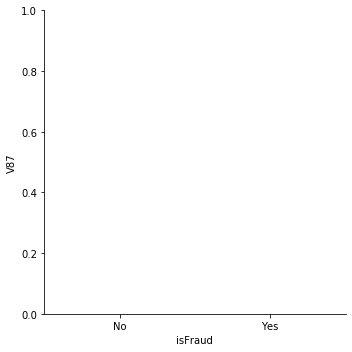

In [29]:
# print(dfo['V87'])
sns.catplot(x="isFraud", y="V87", kind="box", order=["No", "Yes"], data=dfo)